In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [116]:
data = pd.read_csv('../data/gr4j_data.csv', index_col=0, parse_dates=True)
data2 = pd.read_csv('../data/hbv_s_data.csv', index_col=0, parse_dates=True)

In [147]:
def gr4j_simulation(data, params):
    
    """
    Input:
    1. Meteorological forcing 
        data - pandas dataframe with correspondent columns
        for temperature ('Temp') and potential evaporation ('Evap')
    2. list of model parameters:
        X1 : production store capacity (X1 - PROD) [mm]
            [0, 1500]
        X2 : intercatchment exchange coefficient (X2 - CES) [mm/day]
            [-10, 5]
        X3 : routing store capacity (X3 - ROUT) [mm]
            [1, 500]
        X4 : time constant of unit hydrograph (X4 - TB) [day]
            [0.5, 4.0]
    """
    # 1. read the data
    Prec = data['Prec']
    #Prec = cemaneige_simulation(data, [])
    Evap = data['Evap']
    # 2. parameters initialization
    X1, X2, X3, X4 = params
    
    # parameter for unit hydrograph lenght
    NH = 20
    # 3. initialization of model states to zero
    # states of production St[0] and routing St[1] reservoirs holder
    St = np.array([X1/2, X3/2])
    Q = np.zeros(len(Prec))
    
    # Unit hydrograph states holders
    StUH1 = np.zeros(NH)
    StUH2 = np.zeros(2*NH)
      
    # 4. computation of UH ordinates
    def SS1(I,C,D):
        '''
        Values of the S curve (cumulative HU curve) of GR unit hydrograph UH1
        Inputs:
           C: time constant
           D: exponent
           I: time-step
        Outputs:
           SS1: Values of the S curve for I
        '''
        FI = I+1
        if FI <= 0: SS1 = 0
        elif FI < C: SS1 = (FI/C)**D
        else: SS1 = 1
        return SS1
    
    def SS2(I,C,D):
        '''
        Values of the S curve (cumulative HU curve) of GR unit hydrograph UH2
        Inputs:
           C: time constant
           D: exponent
           I: time-step
        Outputs:
           SS2: Values of the S curve for I
        '''
        FI = I+1
        if FI <= 0: SS2 = 0
        elif FI <= C: SS2 = 0.5*(FI/C)**D
        elif C < FI <= 2*C: SS2 = 1 - 0.5*(2 - FI/C)**D
        else: SS2 = 1
        return SS2
    
    def UH1(C, D):
        '''
        C Computation of ordinates of GR unit hydrograph UH1 using successive differences on the S curve SS1
        C Inputs:
        C    C: time constant
        C    D: exponent
        C Outputs:
        C    OrdUH1: NH ordinates of discrete hydrograph
        '''
        OrdUH1 = np.zeros(NH)
        for i in range(NH):
            OrdUH1[i] = SS1(i, C, D)-SS1(i-1, C, D)
        return OrdUH1
    
    def UH2(C, D):
        '''
        C Computation of ordinates of GR unit hydrograph UH1 using successive differences on the S curve SS1
        C Inputs:
        C    C: time constant
        C    D: exponent
        C Outputs:
        C    OrdUH1: NH ordinates of discrete hydrograph
        '''
        OrdUH2 = np.zeros(2*NH)
        for i in range(2*NH):
            OrdUH2[i] = SS2(i, C, D)-SS2(i-1, C, D)
        return OrdUH2
    
    OrdUH1 = UH1(X4, 2.5)
    OrdUH2 = UH2(X4, 2.5)
    
    # timestep implementation
    for t in range(len(Prec)):
        # interception and production store
        # check how connects Evap and Precip
        # case 1. No effective rainfall
        if Prec[t] <= Evap[t]:
            # net evapotranspiration capacity
            EN = Evap[t] - Prec[t]
            # net rainfall
            PN = 0
            # part of production store capacity that suffers deficit
            WS = EN/X1
            # control WS
            if WS > 13: WS = 13
            TWS = np.tanh(WS)
            # part of production store capacity has an accumulated rainfall
            Sr = St[0]/X1
            # actual evaporation rate (will evaporate from production store)
            ER = St[0]*(2 - Sr)*TWS/(1 + (1 - Sr)*TWS)
            # actual evapotranspiration
            AE = ER + Prec[t]
            # production store capacity update
            St[0] = St[0] - ER
            # control state of production store
            if St[0] < 0: St[0] = 0
            # water that reaches routing functions
            PR = 0
        # case 2. Effective rainfall produces runoff
        else:
            # net evapotranspiration capacity
            EN = 0
            # actual evapotranspiration
            AE = Evap[t]
            # net rainfall
            PN = Prec[t] - Evap[t]
            # part of production store capacity that holds rainfall
            WS = PN/X1
            # control WS
            if WS > 13: WS = 13
            TWS = np.tanh(WS)
            # active part of production store
            Sr = St[0]/X1
            # amount of net rainfall that goes directly to the production store
            PS = X1*(1 - Sr*Sr)*TWS/(1 + Sr*TWS)
            # water that reaches routing functions
            PR = PN - PS
            # production store capacity update
            St[0] = St[0] + PS
            # control state of production store
            if St[0] < 0: St[0] = 0
        
        # percolation from production store
        Sr = St[0]/X1
        Sr = Sr * Sr
        Sr = Sr * Sr
        # percolation leakage from production store
        PERC = St[0]*(1 - 1/np.sqrt(np.sqrt(1 + Sr/25.62891)))
        # production store capacity update
        St[0] = St[0] - PERC
        # update amount of water that reaches routing functions
        PR = PR + PERC
        
        # split of effective rainfall into the two routing components
        PRHU1 = PR*0.9
        PRHU2 = PR*0.1
        
        # convolution of unit hydrograph UH1
        for k in range(int( max(1, min(NH-1, int(X4+1))) )):
            StUH1[k] = StUH1[k+1] + OrdUH1[k] * PRHU1
        StUH1[NH-1] = OrdUH1[NH-1] * PRHU1
        
        # convolution of unit hydrograph UH2
        for k in range(int( max(1, min(2*NH-1, 2*int(X4+1))) )):
            StUH2[k] = StUH2[k+1] + OrdUH2[k] * PRHU2
        StUH2[2*NH-1] = OrdUH2[2*NH-1] * PRHU2
        
        # potential intercatchment semi-exchange
        # part of routing store 
        Rr = St[1]/X3
        EXCH = X2*Rr*Rr*Rr*np.sqrt(Rr)
        
        # routing store
        AEXCH1 = EXCH
        if St[1] + StUH1[0] + EXCH < 0: AEXCH1 = -St[1] - StUH1[0]
        # update state 2
        St[1] = St[1] + StUH1[0] + EXCH
        # control state 2
        if St[1] < 0: St[1] = 0
        Rr = St[1]/X3
        Rr = Rr * Rr
        Rr = Rr * Rr
        QR = St[1] * (1 - 1/np.sqrt(np.sqrt(1+Rr)))
        # update state 2
        St[1] = St[1] - QR
        
        # runoff from direct branch QD
        AEXCH2 = EXCH
        if StUH2[0] + EXCH < 0: AEXCH2 = -StUH2[0]
        QD = max(0, StUH2[0] + EXCH)
        
        # total runoff
        Q[t] = QR + QD
    
    # control total runoff
    Q = np.where(Q >= 0, Q, 0)
        
    return Q

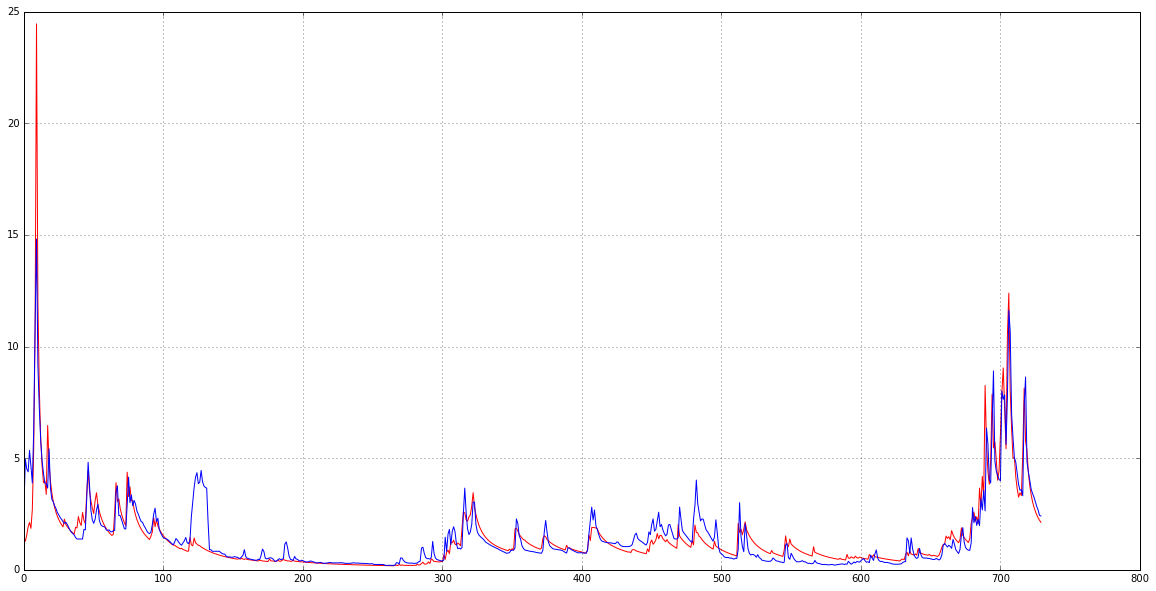

In [148]:
Qsim = gr4j_simulation(data, [320, 2.5, 70, 0])
Qobs = data.Qobs

plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, '-r', 
         range(len(Qobs)), Qobs, '-b')
plt.grid(True)

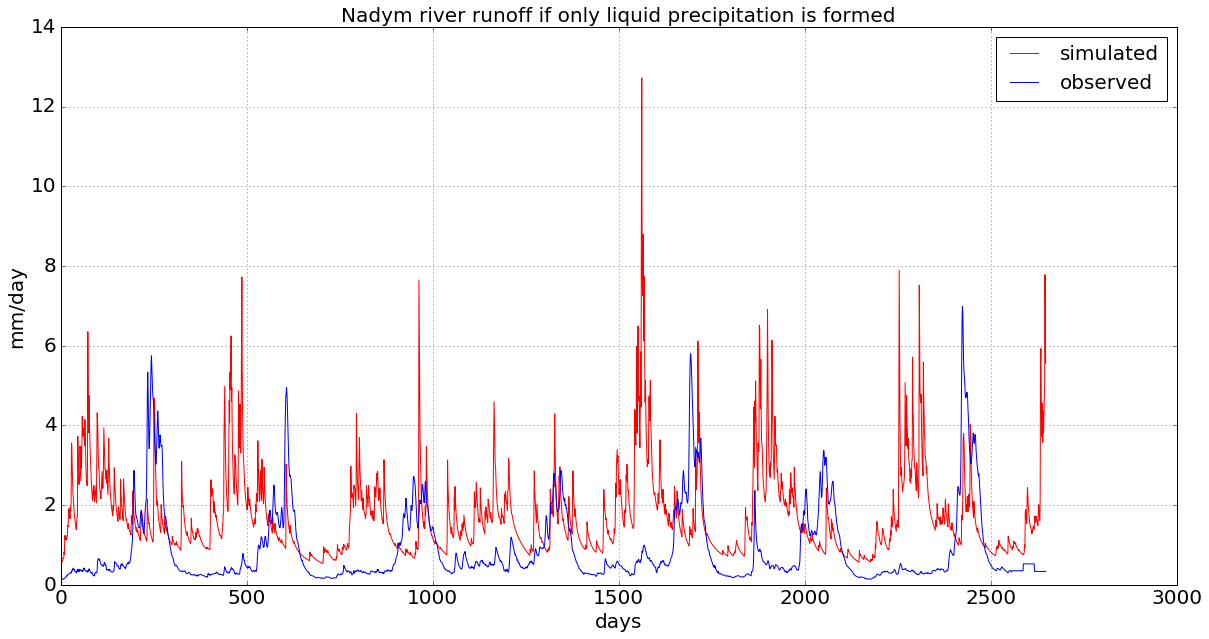

In [149]:
Qsim = gr4j_simulation(data2, [500, 2.5, 40, 0])
Qobs = data2.Qobs
plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, '-r', 
         range(len(Qobs)), Qobs, '-b')
plt.legend(['simulated', 'observed'],prop={'size':20})
plt.xlabel('days', size=20)
plt.xticks(size=20)
plt.ylabel('mm/day', size=20)
plt.yticks(size=20)
plt.title('Nadym river runoff if only liquid precipitation is formed', size=20)
plt.grid(True)

In [204]:
def cemaneige_simulation(data, params):
    '''
    Cema-Neige snow model
    
    Input:
    1. Data - pandas dataframe with correspondent timeseries:
        'Temp'- mean daily temperature (Celsium degrees)
        'Prec'- mean daily precipitation (mm/day)
    2. Params - list of model parameters:
        'CTG' - dimensionless weighting coefficient of the snow pack thermal state
                [0, 1]
        'Kf'  - day-degree rate of melting (mm/(day*celsium degree))
                [1, 10]
    Output:
    Total amount of liquid and melting precipitation daily timeseries 
    (for coupling with hydrological model)
    '''
    
    ### reading the data ###
    Temp = data['Temp']
    Prec = data['Prec']
    FraqSolidPrecip = np.where(Temp < -0.2, 1, 0)
    
    CTG, Kf = params
    
    ### initialization ###
    ## constants ##
    # melting temperature
    Tmelt = 0
    # Threshold for solid precip
    # function for Mean Annual Solid Precipitation
    def MeanAnnualSolidPrecip(data):
        annual_vals = [data.Prec.ix[data.Prec.index.year == i][data.Temp < -0.2].sum()\
                       for i in np.unique(data.index.year)]
        return np.mean(annual_vals)
    
    MASP = MeanAnnualSolidPrecip(data)
    Gthreshold = 0.9*MASP
    MinSpeed = 0.1
    
    ## model states ##
    G = 0
    eTG = 0
    PliqAndMelt = 0
    
    ### ouput of snow model
    PliqAndMelt = np.zeros(len(Temp))
    
    for t in range(len(Temp)):
        ### solid and liquid precipitation accounting
        # liquid precipitation
        Pliq = (1 - FraqSolidPrecip[t]) * Prec[t]
        # solid precipitation
        Psol = FraqSolidPrecip[t] * Prec[t]
        ### Snow pack volume before melt
        G = G + Psol
        ### Snow pack thermal state before melt
        eTG = CTG * eTG + (1 - CTG) * Temp[t]
        # control eTG
        if eTG > 0: eTG = 0
        ### potential melt
        if (int(eTG) == 0) & (Temp[t] > Tmelt):
            PotMelt = Kf * (Temp[t] - Tmelt)
            if PotMelt > G: PotMelt = G
        else:
            PotMelt = 0
        ### ratio of snow pack cover (Gratio)
        if G < Gthreshold:
            Gratio = G/Gthreshold
        else:
            Gratio = 1
        ### actual melt
        Melt = ((1 - MinSpeed) * Gratio + MinSpeed) * PotMelt
        ### snow pack volume update
        G = G - Melt
        ### Gratio update
        if G < Gthreshold:
            Gratio = G/Gthreshold
        else:
            Gratio = 1
        
        ### Water volume to pass to the hydrological model
        PliqAndMelt[t] = Pliq + Melt
    
    return PliqAndMelt

In [205]:
cemaneige_simulation(data2, [0.5, 3])

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

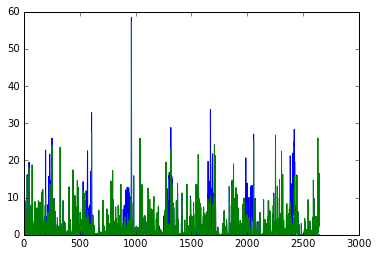

In [206]:
plt.plot(range(len(data2.Prec)), cemaneige_simulation(data2, [0.5, 3]), 
         range(len(data2.Prec)), data2.Prec)

In [202]:
def MeanAnnualSolidPrecip(data):
        annual_vals = [data.Prec.ix[data.Prec.index.year == i][data.Temp < -0.2]\
                       for i in np.unique(data.index.year)]
        return np.mean(annual_vals)

In [203]:
MeanAnnualSolidPrecip(data2)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

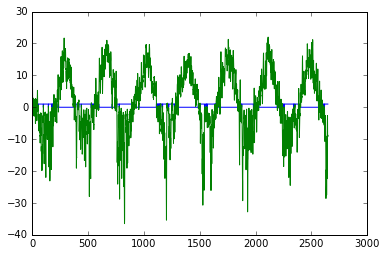

In [171]:
plt.plot(range(len(data2.Temp)), np.where(data2.Temp < -0.2, 1, 0), 
         range(len(data2.Temp)), data2.Temp)

In [213]:
def gr4j_cemaneige(data, params):
        
    """
    Input:
    1. Meteorological forcing 
        data - pandas dataframe with correspondent columns
        for temperature ('Temp') and potential evaporation ('Evap')
    2. list of model parameters:
        GR4J params:
        X1 : production store capacity (X1 - PROD) [mm]
            [0, 1500]
        X2 : intercatchment exchange coefficient (X2 - CES) [mm/day]
            [-10, 5]
        X3 : routing store capacity (X3 - ROUT) [mm]
            [1, 500]
        X4 : time constant of unit hydrograph (X4 - TB) [day]
            [0.5, 4.0]
        Cema-Neige snow model parameters:
        X5 : dimensionless weighting coefficient of the snow pack thermal state
            [0, 1]
        X6 : day-degree rate of melting (mm/(day*celsium degree))
            [1, 10]
    """
    # 1. parameters initialization
    X1, X2, X3, X4, X5, X6 = params
    # 2. read the data
    Prec = cemaneige_simulation(data, [X5, X6])
    Evap = data['Evap']
    
    
    # parameter for unit hydrograph lenght
    NH = 20
    # 3. initialization of model states to zero
    # states of production St[0] and routing St[1] reservoirs holder
    St = np.array([X1/2, X3/2])
    Q = np.zeros(len(Prec))
    
    # Unit hydrograph states holders
    StUH1 = np.zeros(NH)
    StUH2 = np.zeros(2*NH)
      
    # 4. computation of UH ordinates
    def SS1(I,C,D):
        '''
        Values of the S curve (cumulative HU curve) of GR unit hydrograph UH1
        Inputs:
           C: time constant
           D: exponent
           I: time-step
        Outputs:
           SS1: Values of the S curve for I
        '''
        FI = I+1
        if FI <= 0: SS1 = 0
        elif FI < C: SS1 = (FI/C)**D
        else: SS1 = 1
        return SS1
    
    def SS2(I,C,D):
        '''
        Values of the S curve (cumulative HU curve) of GR unit hydrograph UH2
        Inputs:
           C: time constant
           D: exponent
           I: time-step
        Outputs:
           SS2: Values of the S curve for I
        '''
        FI = I+1
        if FI <= 0: SS2 = 0
        elif FI <= C: SS2 = 0.5*(FI/C)**D
        elif C < FI <= 2*C: SS2 = 1 - 0.5*(2 - FI/C)**D
        else: SS2 = 1
        return SS2
    
    def UH1(C, D):
        '''
        C Computation of ordinates of GR unit hydrograph UH1 using successive differences on the S curve SS1
        C Inputs:
        C    C: time constant
        C    D: exponent
        C Outputs:
        C    OrdUH1: NH ordinates of discrete hydrograph
        '''
        OrdUH1 = np.zeros(NH)
        for i in range(NH):
            OrdUH1[i] = SS1(i, C, D)-SS1(i-1, C, D)
        return OrdUH1
    
    def UH2(C, D):
        '''
        C Computation of ordinates of GR unit hydrograph UH1 using successive differences on the S curve SS1
        C Inputs:
        C    C: time constant
        C    D: exponent
        C Outputs:
        C    OrdUH1: NH ordinates of discrete hydrograph
        '''
        OrdUH2 = np.zeros(2*NH)
        for i in range(2*NH):
            OrdUH2[i] = SS2(i, C, D)-SS2(i-1, C, D)
        return OrdUH2
    
    OrdUH1 = UH1(X4, 2.5)
    OrdUH2 = UH2(X4, 2.5)
    
    # timestep implementation
    for t in range(len(Prec)):
        # interception and production store
        # check how connects Evap and Precip
        # case 1. No effective rainfall
        if Prec[t] <= Evap[t]:
            # net evapotranspiration capacity
            EN = Evap[t] - Prec[t]
            # net rainfall
            PN = 0
            # part of production store capacity that suffers deficit
            WS = EN/X1
            # control WS
            if WS > 13: WS = 13
            TWS = np.tanh(WS)
            # part of production store capacity has an accumulated rainfall
            Sr = St[0]/X1
            # actual evaporation rate (will evaporate from production store)
            ER = St[0]*(2 - Sr)*TWS/(1 + (1 - Sr)*TWS)
            # actual evapotranspiration
            AE = ER + Prec[t]
            # production store capacity update
            St[0] = St[0] - ER
            # control state of production store
            if St[0] < 0: St[0] = 0
            # water that reaches routing functions
            PR = 0
        # case 2. Effective rainfall produces runoff
        else:
            # net evapotranspiration capacity
            EN = 0
            # actual evapotranspiration
            AE = Evap[t]
            # net rainfall
            PN = Prec[t] - Evap[t]
            # part of production store capacity that holds rainfall
            WS = PN/X1
            # control WS
            if WS > 13: WS = 13
            TWS = np.tanh(WS)
            # active part of production store
            Sr = St[0]/X1
            # amount of net rainfall that goes directly to the production store
            PS = X1*(1 - Sr*Sr)*TWS/(1 + Sr*TWS)
            # water that reaches routing functions
            PR = PN - PS
            # production store capacity update
            St[0] = St[0] + PS
            # control state of production store
            if St[0] < 0: St[0] = 0
        
        # percolation from production store
        Sr = St[0]/X1
        Sr = Sr * Sr
        Sr = Sr * Sr
        # percolation leakage from production store
        PERC = St[0]*(1 - 1/np.sqrt(np.sqrt(1 + Sr/25.62891)))
        # production store capacity update
        St[0] = St[0] - PERC
        # update amount of water that reaches routing functions
        PR = PR + PERC
        
        # split of effective rainfall into the two routing components
        PRHU1 = PR*0.9
        PRHU2 = PR*0.1
        
        # convolution of unit hydrograph UH1
        for k in range(int( max(1, min(NH-1, int(X4+1))) )):
            StUH1[k] = StUH1[k+1] + OrdUH1[k] * PRHU1
        StUH1[NH-1] = OrdUH1[NH-1] * PRHU1
        
        # convolution of unit hydrograph UH2
        for k in range(int( max(1, min(2*NH-1, 2*int(X4+1))) )):
            StUH2[k] = StUH2[k+1] + OrdUH2[k] * PRHU2
        StUH2[2*NH-1] = OrdUH2[2*NH-1] * PRHU2
        
        # potential intercatchment semi-exchange
        # part of routing store 
        Rr = St[1]/X3
        EXCH = X2*Rr*Rr*Rr*np.sqrt(Rr)
        
        # routing store
        AEXCH1 = EXCH
        if St[1] + StUH1[0] + EXCH < 0: AEXCH1 = -St[1] - StUH1[0]
        # update state 2
        St[1] = St[1] + StUH1[0] + EXCH
        # control state 2
        if St[1] < 0: St[1] = 0
        Rr = St[1]/X3
        Rr = Rr * Rr
        Rr = Rr * Rr
        QR = St[1] * (1 - 1/np.sqrt(np.sqrt(1+Rr)))
        # update state 2
        St[1] = St[1] - QR
        
        # runoff from direct branch QD
        AEXCH2 = EXCH
        if StUH2[0] + EXCH < 0: AEXCH2 = -StUH2[0]
        QD = max(0, StUH2[0] + EXCH)
        
        # total runoff
        Q[t] = QR + QD
    
    # control total runoff
    Q = np.where(Q >= 0, Q, 0)
        
    return Q

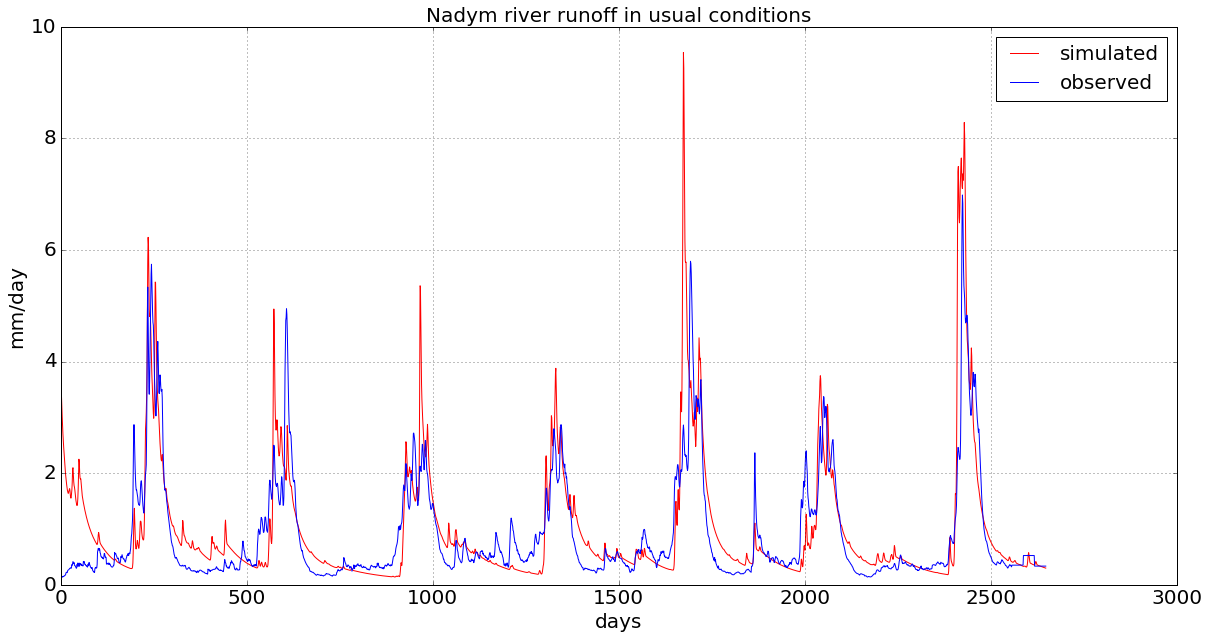

In [272]:
Qsim = gr4j_cemaneige(data2, [100, 1.5, 500, 3.9, 1, 7])
Qobs = data2.Qobs
plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, '-r', 
         range(len(Qobs)), Qobs, '-b')
plt.legend(['simulated', 'observed'],prop={'size':20})
plt.xlabel('days', size=20)
plt.xticks(size=20)
plt.ylabel('mm/day', size=20)
plt.yticks(size=20)
plt.title('Nadym river runoff in usual conditions', size=20)
plt.grid(True)